In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline




In [3]:
# load pickled distortion matrix
with open('camera_cal/output/cal_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [12]:
# Read in an image
#img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

In [83]:
# Convert to grayscale
def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    return gray

In [84]:
def abs_sobel_thresh(img, orient='x', thresh_min=5, thresh_max=95):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sobel_binary

In [85]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobelxy = np.absolute(abs_sobelxy)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    #print(scaled_sobel)
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mag_binary

In [86]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met # no scaling
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [87]:
def perspactive_transform(img, nx, ny, mtx, dist):
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], gray.shape[0])
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    #print(np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]]))
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M

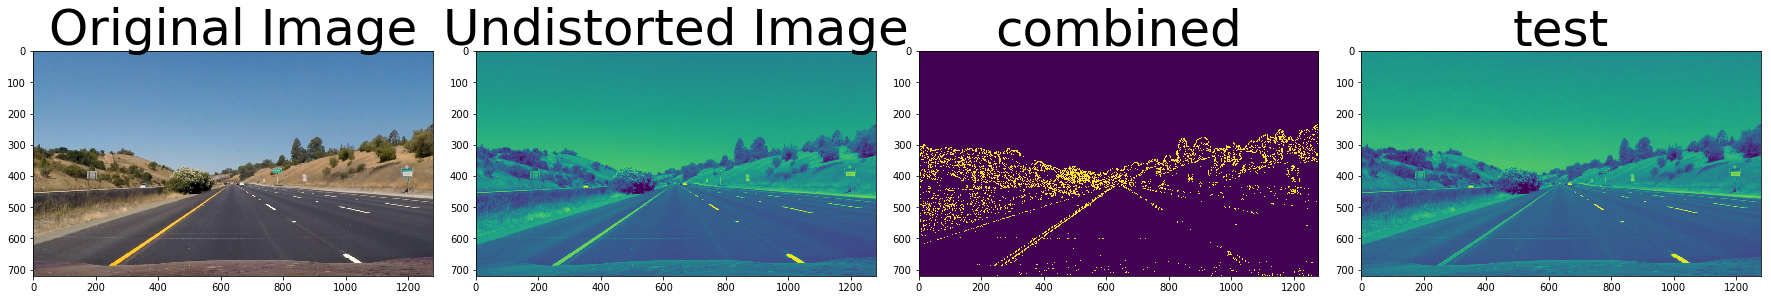

In [96]:
img=mpimg.imread('./test_images/straight_lines1.jpg')

undistorted = cal_undistort(img)
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# Apply each of the thresholding functions
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
gray = to_grayscale(img)
gradx = abs_sobel_thresh(gray, orient='x', thresh_min=15, thresh_max=155)
grady = abs_sobel_thresh(gray, orient='y', thresh_min=5, thresh_max=95)
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gray)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(combined)
ax3.set_title('combined', fontsize=50)
ax4.imshow(l_channel)
ax4.set_title('test', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

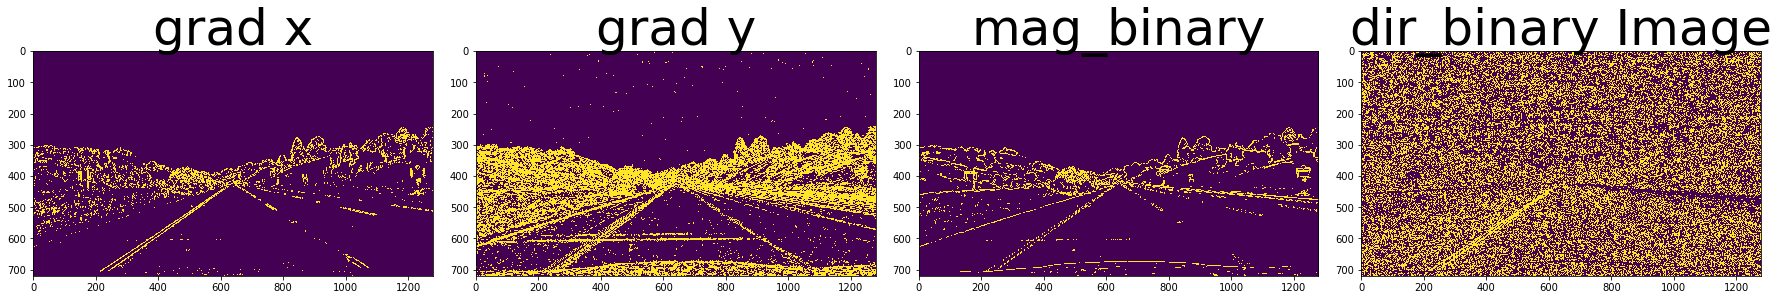

In [75]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx)
ax1.set_title('grad x', fontsize=50)
ax2.imshow(grady)
ax2.set_title('grad y', fontsize=50)
ax3.imshow(mag_binary)
ax3.set_title('mag_binary', fontsize=50)
ax4.imshow(dir_binary)
ax4.set_title('dir_binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)